In [1]:
# Import necessary libraries
import jax.numpy as jnp
from jax import random, grad, jit, lax
from jax.scipy.linalg import inv, svd, eigh, det
from jax.numpy.linalg import norm
from tqdm import tqdm
from sklearn.datasets import make_spd_matrix
from jax_models import visualize_observations, Lorenz96, KuramotoSivashinsky, generate_true_states, generate_gc_localization_matrix
from jax_filters import ensrf_steps
import jax
import matplotlib.pyplot as plt
from jax.tree_util import Partial
from functools import partial
from jax_vi import KL_gaussian, log_likelihood, KL_sum

# num_steps = 200  # Number of simulation steps
# n = 256 # Dimensionality of the state space for KS model
# observation_interval = 5  # Interval at which observations are made
# dt = 0.25  # Time step for the KS model
# ks_model = KuramotoSivashinsky(dt=dt, s=n, l=22, M=16)
# ks_step = Partial(ks_model.step)

N = 10 # number of Monte Carlo samples
F = 8.0
dt = 0.05
num_steps = 250  # Number of time steps
J0 = 0
n = 40   # Number of state variables
key = random.PRNGKey(0)  # Random key for reproducibility
x0 = random.normal(key, (n,))
initial_state  = x0
# Noise covariances
Q = 0.03 * jnp.eye(n)  # Process noise covariance
R = 0.01 * jnp.eye(n)  # Observation noise covariance
# Observation matrix (identity matrix for direct observation of all state variables)
H = jnp.eye(n)

n_ensemble = 10
observation_interval = 1
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state



l96_model = Lorenz96(dt = dt, F = 8)
l96_step = Partial(l96_model.step)
# Generate true states and observations using the Lorenz '96 model

state_transition_function = l96_model.step
observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)

In [2]:
# plt.plot(true_states[:, 1])
# plt.plot(observations[:, 1])
# observations[:, 1]

In [3]:
# localization_matrix = np.ones((n, n))#generate_gc_localization_matrix(n, 5)
# ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
# e, c = ensrf_steps(l96_step, n_ensemble, ensemble_init, observations, H, Q, R, localization_matrix, 1.0, key)
# plt.plot(e.mean(axis=(1,2)))
# plt.plot(true_states.mean(axis=1))
# #plt.plot([np.trace(cc) for cc in c])

In [4]:
# plt.pcolormesh(c[-1])
# plt.colorbar()

In [5]:
@jit
def var_cost(radius, inflation, model, ensemble_init, observations, H, Q, R, key, J, J0):
    localization_matrix = generate_gc_localization_matrix(n, radius)
    states, covariances = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(ensemble_mean, covariances, n, model, Q, key, N)
    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, ensemble_mean, covariances), observations, H, R, J, J0)  # Sometimes the covariances are negative definite. Fix
    cost = kl_sum - jnp.mean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    print(cost)
    return cost

In [7]:
import properscoring
from IPython.display import clear_output
from jax import grad
from tqdm.notebook import tqdm
import jax.numpy as jnp
from jax import random


# Modification: Use grad to compute the gradient with respect to the radius parameter
var_cost_grad = grad(var_cost, argnums=0)

inflation = 1.2  # Example starting value for inflation
radius_opt = 1.4
alpha = 1e-4  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 10  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T

crpss = []
radii = []
rmses=[]

for i in tqdm(range(50)):
    key, subkey = random.split(key)
        
    # Gradient descent step for inflation parameter
    grad_radius = var_cost_grad(radius_opt, inflation, l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)
    print(grad_radius)
    radius_opt -= alpha * grad_radius  # Update inflation parameter
    radii.append(radius_opt)
    localization_matrix = generate_gc_localization_matrix(n, radius_opt)

    states, _ = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    rmse = jnp.sqrt(jnp.mean((ensemble_mean - true_states)**2))
    rmses.append(rmse)
    crps = properscoring.crps_ensemble(true_states, states).mean(axis=1).mean()
    crpss.append(crps)
    #clear_output(wait=True)
    
    print(radius_opt, crps)

  0%|          | 0/50 [00:00<?, ?it/s]

TypeError: ensrf_steps() missing 2 required positional arguments: 'inflation' and 'key'

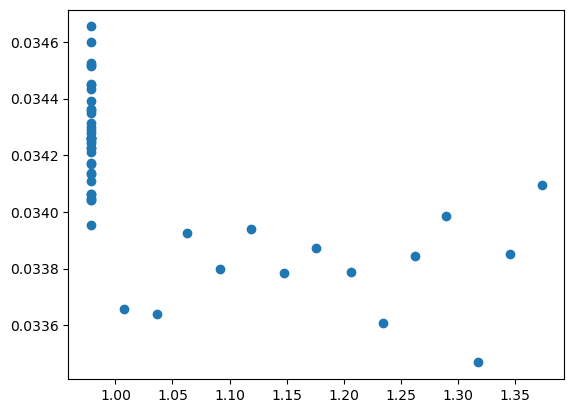

In [10]:
plt.scatter(radii, crpss)

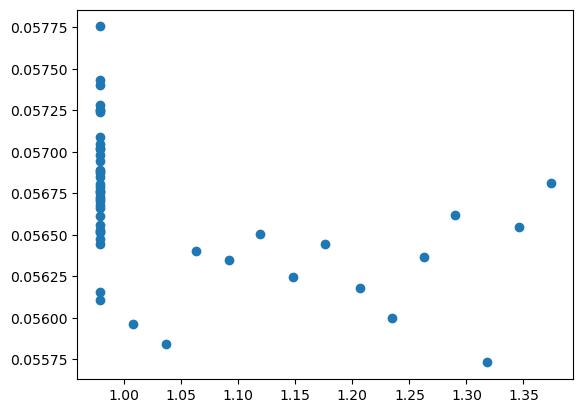

In [11]:
plt.scatter(radii, rmses)